This notebook creates and then trains naive templates

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.interpolate import interp1d

from modules import get_bandpass_dict, get_eff_wavelen, Sed, \
                    create_training_sets, train_templates

In [2]:
# plotting style
%config InlineBackend.figure_format = 'retina'
plt.style.use('paper.mplstyle')
twocol = 7.1014
onecol = 3.35

Load the filters

In [3]:
bandpass_dict = get_bandpass_dict()

Load the galaxy redshift catalog

In [4]:
with open('data/galaxy_catalog.pkl', 'rb') as input:
    galaxies = pickle.load(input)

Create the naive templates

In [94]:
def log_norm(x,mode,sigma,A):
    mu = np.log(mode) + sigma**2
    f1 = lambda x: 1e5/(x*sigma*np.sqrt(2*np.pi))*np.exp(-(np.log(x)-mu)**2/(2*sigma**2))
    f = lambda x: A/f1(mode)*f1(x)
    return f(x)

N = 9
modes = np.linspace(5000,1000,N)
sigmas = np.linspace(0.6,0.8,N)
As = np.geomspace(1,10,N)

# save the templates as Seds
x = np.linspace(10,23000,100)
naive_templates = dict()
for i in range(N):
    template = Sed()
    template.wavelen = x
    template.flambda = log_norm(x,modes[i],sigmas[i],As[i])
    naive_templates["naive"+str(i+1)] = template

Create training sets and plot them

In [95]:
%%time
training_sets = create_training_sets(naive_templates,galaxies,bandpass_dict)

CPU times: user 43.8 s, sys: 52 ms, total: 43.8 s
Wall time: 43.8 s


Number of fluxes in each training set:
[101009, 21801, 26602, 25393, 21124, 18108, 15959, 15754, 14728]


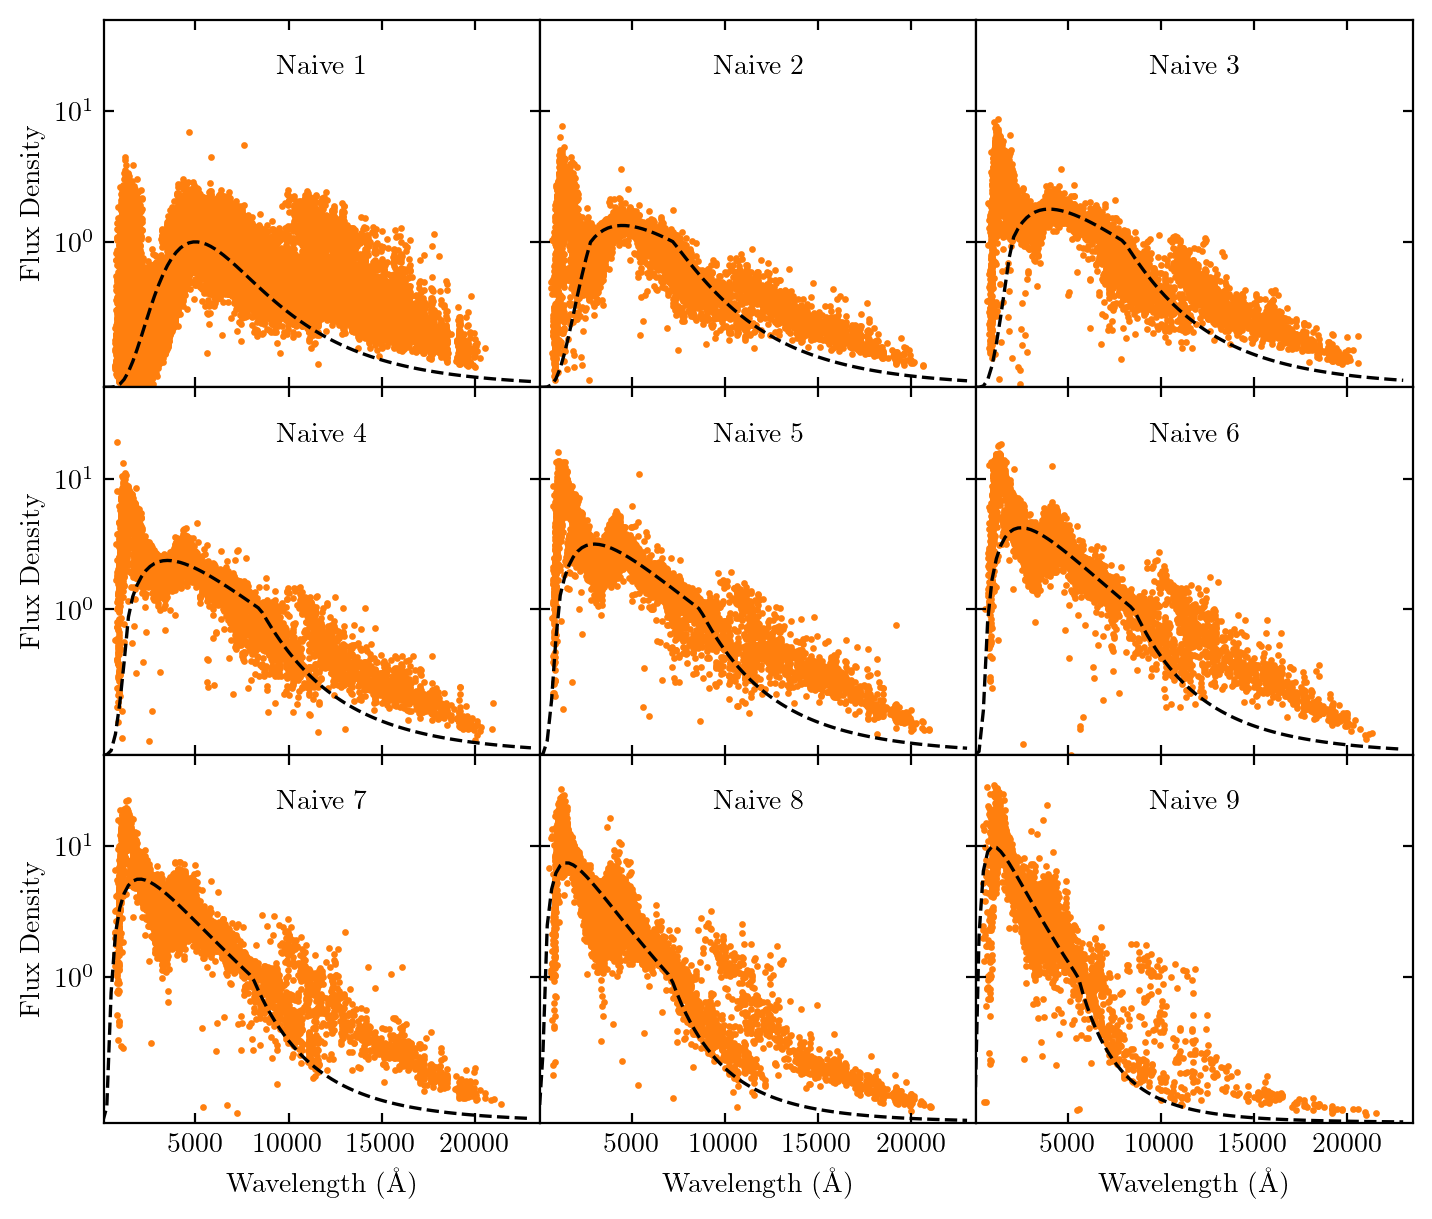

In [108]:
ncols = 3
nrows = int(N/ncols+0.5)
fig, axes = plt.subplots(nrows,ncols,sharex='all',sharey='all',figsize=(twocol,twocol*nrows/ncols*0.85))

print("Number of fluxes in each training set:")
print([len(i) for i in training_sets.values()])

for i,ax in enumerate(axes.flatten()):
    
    wavelen = [row[0] for row in training_sets["naive"+str(i+1)]]
    fluxes  = [row[1] for row in training_sets["naive"+str(i+1)]]
    ax.scatter(wavelen, fluxes, s=2, c="C1")
    
    template = naive_templates["naive"+str(i+1)]
    ax.plot(template.wavelen, template.flambda, ls="--", c="k")
    
    ax.text(0.5,0.85,"Naive "+str(i+1),transform=ax.transAxes,ha="center")
    
plt.xlim(100,23500)
plt.ylim(0,50)
plt.yscale('symlog',linthreshy=1)
for ax in axes[-1,:]:
    ax.set_xlabel('Wavelength ($\mathrm{\AA}$)')
for ax in axes[:,0]:
    ax.set_ylabel('Flux Density')
    
plt.yticks([1,10])

fig.tight_layout(pad=0.5, h_pad=0, w_pad=0)
plt.show()

#fig.savefig('plots/naive_untrained.pdf')

Now train the templates

In [98]:
%%time
trained_templates, final_sets = train_templates(naive_templates, galaxies, bandpass_dict, N_iter=1, w=0.75)

Round 1/5
0.002652299640729442
0.0032348193604401737
0.0027094137412318905
0.00284033961159295
0.0031075627175931085
0.0033576895735041106
0.0034538282956742424
0.003661189734229839
0.008071488459075316
Round 2/5
0.0029666283205398523
0.002541041647440882
0.0038298804448068952
0.0028285128529276144
0.002652336896849056
0.0026926385521994153
0.0033885121287879124
0.003591755765148052
0.011973129462395518
Round 3/5
0.00324152730036048
0.002405744471363332
0.004046393621399831
0.0028219766492680013
0.002720556264921374
0.002478613897155778
0.0032585415099532587
0.003699505127892956
0.018416700228007038
Round 4/5
0.0034282200439472678
0.0025202193567427293
0.0037813234055503126
0.002741969433211517
0.002776347879968939
0.002504124303766382
0.0031468418521021025
0.007112674842513998
0.007922896994545544
Round 5/5
0.0036322914792503965
0.002642954196999892
0.0034753721581793
0.0026277300663322778
0.0027936645106770783
0.002631015094003869
0.0031041644545875195
0.006825922599531302
0.00796403

Number of fluxes in each training set:
[61082, 42217, 23178, 35635, 29390, 27829, 21649, 15635, 3863]


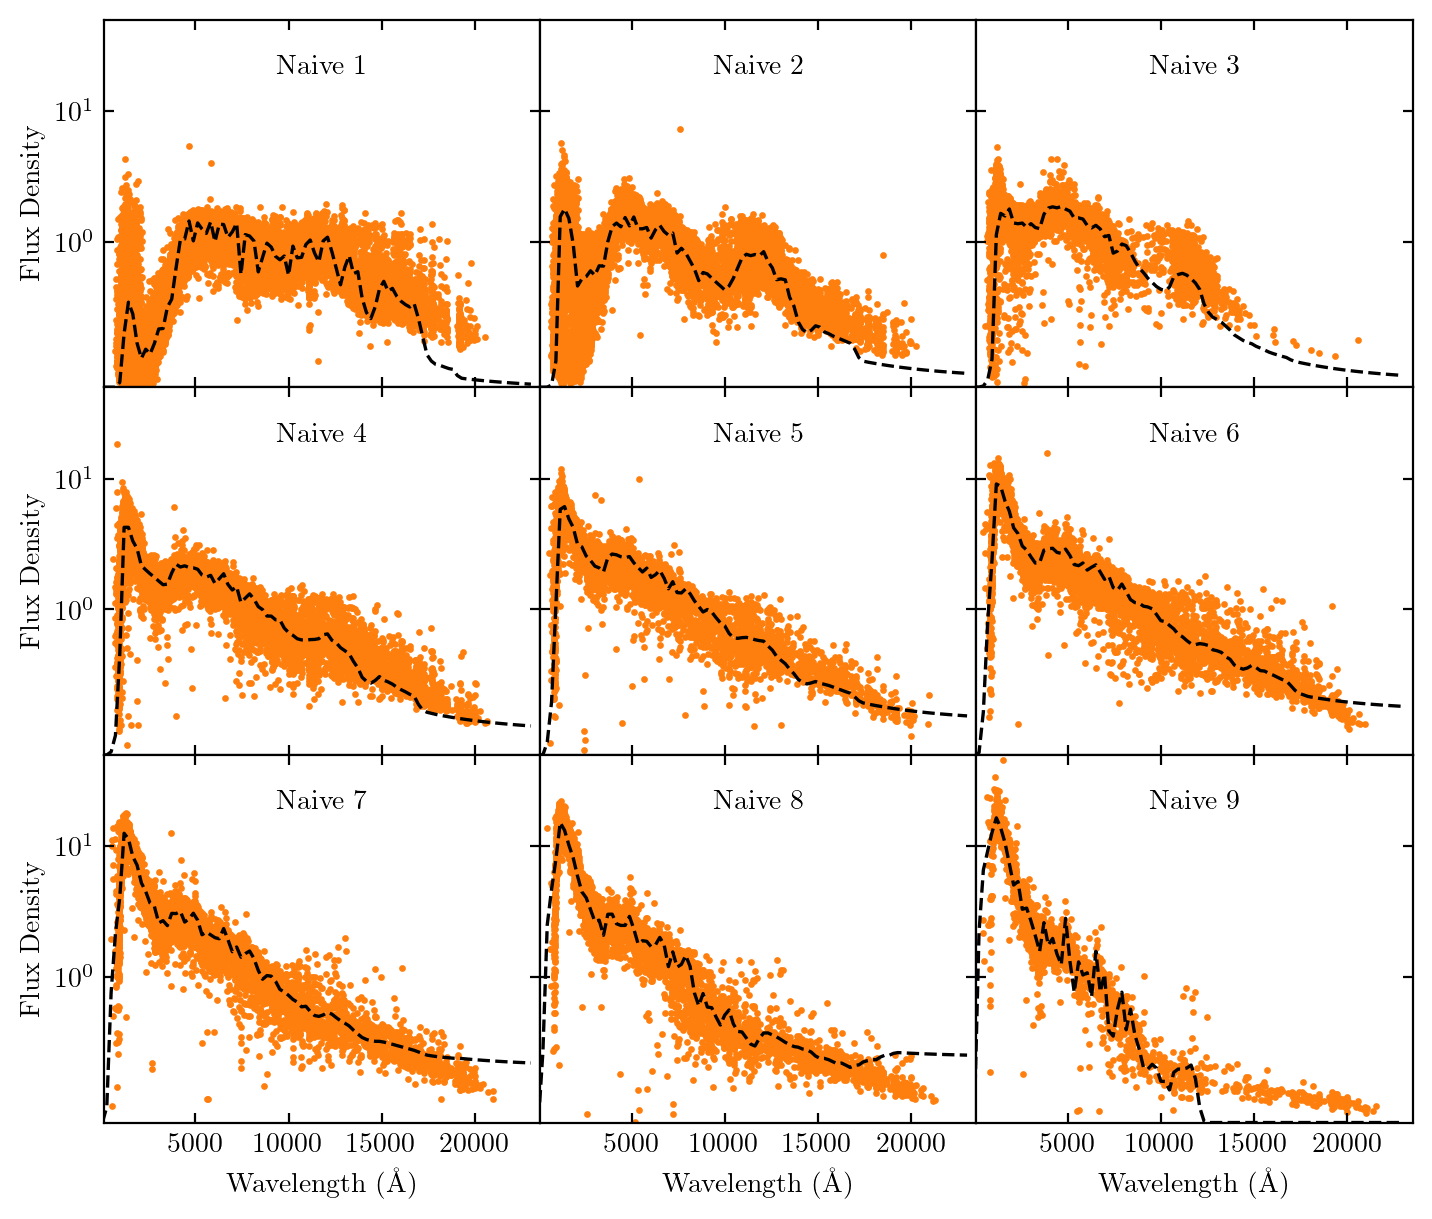

In [112]:
ncols = 3
nrows = int(N/ncols+0.5)
fig, axes = plt.subplots(nrows,ncols,sharex='all',sharey='all',figsize=(twocol,twocol*nrows/ncols*0.85))

print("Number of fluxes in each training set:")
print([len(i) for i in final_sets.values()])

for i,ax in enumerate(axes.flatten()):
    
    wavelen = [row[0] for row in final_sets["naive"+str(i+1)]]
    fluxes  = [row[1] for row in final_sets["naive"+str(i+1)]]
    ax.scatter(wavelen, fluxes, s=2, c="C1")
    
    template = trained_templates["naive"+str(i+1)]
    ax.plot(template.wavelen, template.flambda, ls="--", c="k")
    
    ax.text(0.5,0.85,"Naive "+str(i+1),transform=ax.transAxes,ha="center")
    
plt.xlim(100,23500)
plt.ylim(0,50)
plt.yscale('symlog',linthreshy=1)
for ax in axes[-1,:]:
    ax.set_xlabel('Wavelength ($\mathrm{\AA}$)')
for ax in axes[:,0]:
    ax.set_ylabel('Flux Density')
    
plt.yticks([1,10])

fig.tight_layout(pad=0.5, h_pad=0, w_pad=0)
plt.show()

#fig.savefig('plots/naive_trained.pdf')

Save the results!

In [103]:
for template in trained_templates:
    file = open('templates/'+template+'.sed','w')
    x = trained_templates[template].wavelen
    y = trained_templates[template].flambda
    for i in range(len(x)):
        file.write("{0:<10.2f}{1:<10.2f}\n".format(x[i],y[i]))
    file.close()

Plot the naive templates with the CWW+SB4 Templates

In [104]:
cwwsb4 = ['El_B2004a', 'Sbc_B2004a', 'Scd_B2004a', 'Im_B2004a', 'SB3_B2004a', 
                'SB2_B2004a', 'ssp_25Myr_z008', 'ssp_5Myr_z008']

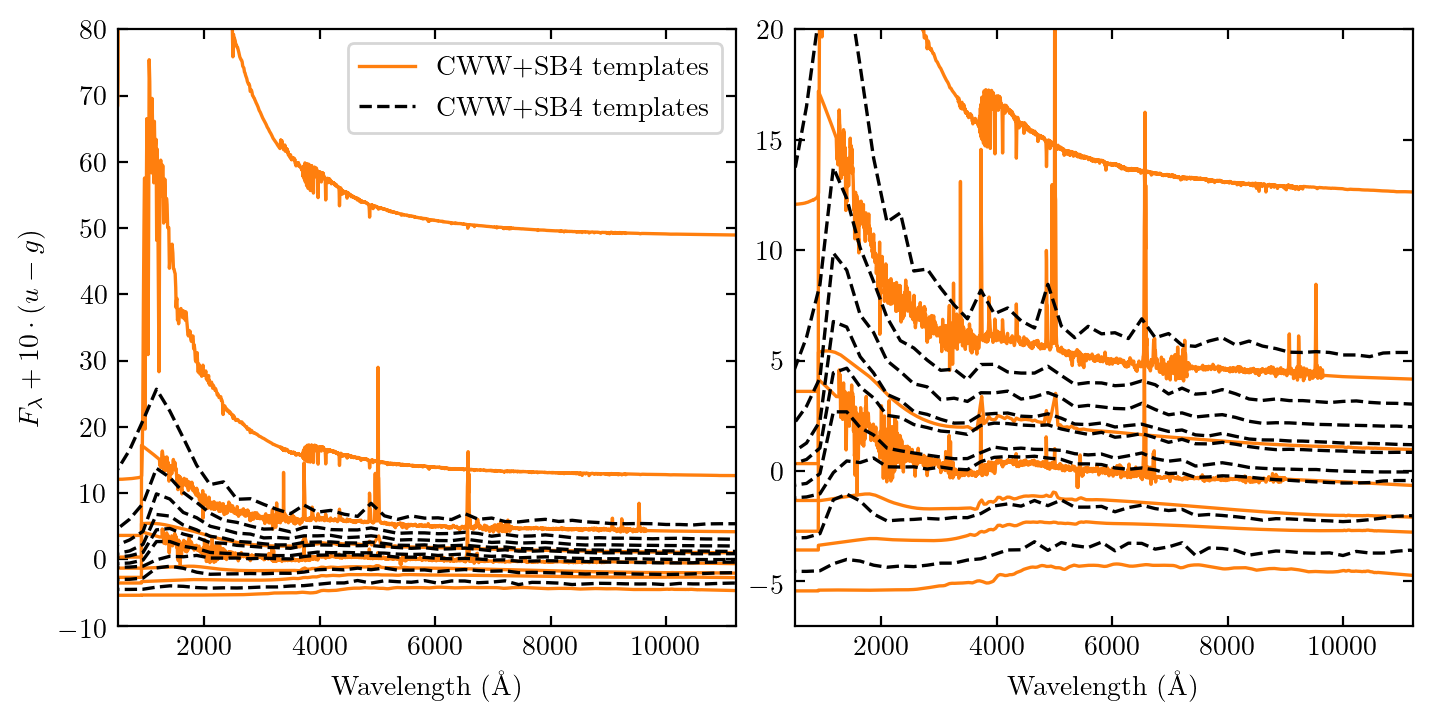

In [105]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(twocol,twocol/2))

colors = ['C1','k']
styles = ['-','--']
titles = ['CWW+SB4 templates', "Naive templates"]
for i,template_set in enumerate([cwwsb4,trained_templates]):

    for template in template_set:
        name = 'templates/'+template+'.sed'
        x,y = np.loadtxt(name,unpack=True)
        f = interp1d(x,y)
        y /= f(8000)

        sed = Sed()
        sed.wavelen = x
        sed.flambda = y

        u = sed.flux(bandpass_dict['u'])
        g = sed.flux(bandpass_dict['g'])
        template_fluxes = sed.fluxlist(bandpass_dict)
        
        ax1.plot(x,y+10*(u-g),c=colors[i],ls=styles[i])
        ax2.plot(x,y+10*(u-g),c=colors[i],ls=styles[i])

ax1.plot([5000],[30],c='C1',label='CWW+SB4 templates')
ax1.plot([5000],[30],c='k',ls='--',label='CWW+SB4 templates')
ax1.legend()

ax1.set_ylim(-10,80)
ax1.set_xlim(500,11200)
ax1.set_ylabel('$F_\lambda + 10 \cdot (u-g)$') 
ax1.set_xlabel('Wavelength ($\mathrm{\AA}$)')

ax2.set_ylim(-7,20)
ax2.set_xlim(500,11200)
ax2.set_xlabel('Wavelength ($\mathrm{\AA}$)')

fig.tight_layout(pad=0.5)
#fig.savefig("plots/naive_vs_cwwsb4.pdf")
plt.show()